- Most/least responsive cells
- Most/least impactrul (damaging) drugs

- Most/least predictive cells (lowest error)
- Most/least predictive drugs (lowest error)

------------

- Encode count of cells/drugs
- Separate results by study

------------

- https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial
- https://seaborn.pydata.org/tutorial/distributions.html#distribution-tutorial

In [1]:
!which python

/Users/apartin/anaconda3/bin/python


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from glob import glob

import sklearn
import numpy as np
import pandas as pd
from math import sqrt

TO_PLOT = False

In [3]:
# runs_dir_name = 'out_lgbm'
runs_dir_name = 'out_lgbm_cls'
file_path = Path.cwd()
print(file_path)

/Users/apartin/Box Sync/projects/DrugResponseViz/notebooks


In [4]:
out_figs = file_path / 'out_figs_cls'
os.makedirs(out_figs, exist_ok=True)

In [5]:
runs_dir_path = Path(file_path / '..' / runs_dir_name)
runs_dirs = [Path(p) for p in glob(str(runs_dir_path/'run_*'))]
# pred = pd.read_csv(os.path.join(predsdir, 'dev_lgb_reg_preds.csv'))

In [6]:
# Load cell metadata
cancer_types = pd.read_csv(file_path/'../data/combined_cancer_types', sep='\t', names=['CELL', 'CTYPE'])
print(cancer_types.shape)
display(cancer_types[:2])

# cmeta = pd.read_csv(file_path/'../data/combined_metadata_2018May.txt', sep='\t')
# print(cmeta.shape)

# dmeta = pd.read_csv(file_path/'../data/drug_info', sep='\t')
# print(dmeta.shape)

(14590, 2)


,CELL,CTYPE
0,CCLE.ALLSIL,Acute_Lymphoblastic_Leukemia
1,CCLE.DND41,Acute_Lymphoblastic_Leukemia


In [7]:
# mltype = 'reg'
mltype = 'cls'

In [8]:
def plot_target(data_to_plot, y_name, x_name, kind='box', hue_name=None, height=None, aspect=None):
    """ Plot function. """
    if hue_name:
        g = sns.catplot(data=data_to_plot, y=y_name, x=x_name, kind=kind, hue=hue_name, **args);
    else:
        g = sns.catplot(data=data_to_plot, y=y_name, x=x_name, kind=kind, **args);
    return g

# Aggregate predictions from all runs (shuffles/splits)

In [9]:
def reorg_cols(df):
    cols = df.columns.tolist()
    cols.remove('run')
    return df[['run'] + cols]
    
def agg_preds_from_cls_runs(runs_dirs, phase='_te.csv'):
    """ Aggregate predictions bootstraped ML trainings. """
    prd_te = []
    for i, dir_name in enumerate(runs_dirs):
        if '_tr.csv' in phase:
            prd_tr_ = pd.read_csv(dir_name/'preds_tr.csv')
        elif '_vl.csv' in phase:
            prd_vl_ = pd.read_csv(dir_name/'preds_vl.csv')
        elif '_te.csv' in phase:
            prd_te_ = pd.read_csv(dir_name/'preds_te.csv')
        
        # prd_te_['err'] = abs(prd_te_['y_true'] - prd_te_['y_pred'])      # add col 'err'
        prd_te_['run'] = str(dir_name).split(os.sep)[-1].split('_')[-1]  # add col 'run' identifier
        prd_te.append(prd_te_)  # append run data

        if i%20==0:
            print(f'Processing {dir_name}')
            
    # Aggregate to df
    prd_te = pd.concat(prd_te, axis=0)
    
    # Reorganize cols
    prd_te = reorg_cols(prd_te).sort_values('run').reset_index(drop=True).reset_index().rename(columns={'index': 'idx'})
    return prd_te

In [10]:
# Concat preds from all runs      
prd_te_all = agg_preds_from_cls_runs(runs_dirs, phase='_te.csv')
prd_te_all.insert(loc=2, column='source', value=[s.split('.')[0].lower() for s in prd_te_all['CELL']]) # add 'source' column

print(prd_te_all.shape)
display(prd_te_all.head())

Processing /Users/apartin/Box Sync/projects/DrugResponseViz/notebooks/../out_lgbm_cls/run_s036
Processing /Users/apartin/Box Sync/projects/DrugResponseViz/notebooks/../out_lgbm_cls/run_s063
Processing /Users/apartin/Box Sync/projects/DrugResponseViz/notebooks/../out_lgbm_cls/run_s078
Processing /Users/apartin/Box Sync/projects/DrugResponseViz/notebooks/../out_lgbm_cls/run_s003
Processing /Users/apartin/Box Sync/projects/DrugResponseViz/notebooks/../out_lgbm_cls/run_s073
(5299400, 8)


,idx,run,source,CELL,DRUG,AUC,y_true,y_pred
0,0,s000,ctrp,CTRP.JURL-MK1,CTRP.208,0.8206,0,0.026105
1,1,s000,ctrp,CTRP.NCI-H716,CTRP.482,0.9072,0,0.003678
2,2,s000,ctrp,CTRP.HCC1500,CTRP.435,0.9570,0,0.001108
3,3,s000,nci60,NCI60.LOX-IMVI,NSC.762,0.8277,0,0.000183
4,4,s000,ctrp,CTRP.RCH-ACV,CTRP.105,0.9630,0,0.004494


# Create summary table

In [11]:
# Some samples contain ambiguous true labels (both 0 and 1)
df = prd_te_all.groupby(['CELL', 'DRUG']).agg({'y_true': np.unique}).reset_index()

print('\nSome samples contain ambiguous true labels (both 0 and 1).')
print(df.y_true.value_counts())

print('\nThe unique types')
print(np.unique([str(type(x)) for x in df.y_true]))

print('\nCreate the number of unique responses per sample.')
df['y_true_unq_vals'] = df.y_true.map(lambda x: len(x) if type(x)==np.ndarray else 1)

print('\nPrint bincount.')
print(df.y_true_unq_vals.value_counts())


Some samples contain ambiguous true labels (both 0 and 1).
0         346350
1          13855
[0, 1]         1
[0, 1]         1
[0, 1]         1
           ...  
[0, 1]         1
[0, 1]         1
[0, 1]         1
[0, 1]         1
[0, 1]         1
Name: y_true, Length: 1489, dtype: int64

The unique types
["<class 'numpy.int64'>" "<class 'numpy.ndarray'>"]

Create the number of unique responses per sample.

Print bincount.
1    360205
2      1487
Name: y_true_unq_vals, dtype: int64


In [12]:
# Summary table
prd_te_all['y_pred_prob_median'] = prd_te_all.y_pred
prd_te_all['y_pred_prob_std'] = prd_te_all.y_pred
prd_te_all['y_pred_cls_0'] = prd_te_all.y_pred.map(lambda x: True if x<=0.5 else False)
prd_te_all['y_pred_cls_1'] = prd_te_all.y_pred.map(lambda x: True if x>0.5 else False)
prd_te_all['y_true_unq_vals'] = prd_te_all.y_true

sm = prd_te_all.groupby(['CELL', 'DRUG']).agg(
    {'y_true': np.unique,
     'y_true_unq_vals': np.unique,
     'y_pred_prob_median': np.median, 'y_pred_prob_std': np.std,
     'y_pred_cls_0': lambda x: int(sum(x)), 'y_pred_cls_1': lambda x: int(sum(x)),
     }).reset_index()

sm['y_true_unq_vals'] = sm.y_true_unq_vals.map(lambda x: len(x) if type(x)==np.ndarray else 1)
display(sm[:3])

,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1
0,CCLE.22RV1,CCLE.1,0,1,0.001621,0.000736,7,0
1,CCLE.22RV1,CCLE.10,0,1,0.001052,0.000662,8,0
2,CCLE.22RV1,CCLE.11,1,1,0.656640,0.063909,0,9


# Filter samples

In [15]:
# Filter out samples with ambiguous true values
sm_dmp = sm[sm.y_true_unq_vals>1]
sm_flt = sm[sm.y_true_unq_vals==1]

print(sm_dmp.shape)
print(sm_flt.shape)

display(sm_flt)

(1487, 8)
(360205, 8)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1
0,CCLE.22RV1,CCLE.1,0,1,0.001621,0.000736,7,0
1,CCLE.22RV1,CCLE.10,0,1,0.001052,0.000662,8,0
2,CCLE.22RV1,CCLE.11,1,1,0.656640,0.063909,0,9
3,CCLE.22RV1,CCLE.12,0,1,0.001233,0.000346,13,0
4,CCLE.22RV1,CCLE.13,0,1,0.039151,0.013782,9,0
...,...,...,...,...,...,...,...,...
361687,gCSI.WM-266-4,gCSI.5,1,1,0.142768,0.016788,7,0
361688,gCSI.WM-266-4,gCSI.6,0,1,0.004280,0.001032,8,0
361689,gCSI.WM-266-4,gCSI.7,0,1,0.002990,0.000518,10,0
361690,gCSI.WM-266-4,gCSI.8,1,1,0.204251,0.049624,13,0


In [16]:
# Add columns of: TP, TN, FN, FP
sm_flt['TP'] = sm_flt.apply(lambda row: row.y_pred_cls_1 if row.y_true==1 else False, axis=1)  # tp
sm_flt['TN'] = sm_flt.apply(lambda row: row.y_pred_cls_0 if row.y_true==0 else False, axis=1)  # tn
sm_flt['FN'] = sm_flt.apply(lambda row: row.y_pred_cls_0 if row.y_true==1 else False, axis=1)  # fn
sm_flt['FP'] = sm_flt.apply(lambda row: row.y_pred_cls_1 if row.y_true==0 else False, axis=1)  # fp

display(sm_flt[:3])

# Prediction Analysis

## Most confident predictions of responders

In [44]:
# Most confident predictions of responders
n_show = 5
rsp_value = 1  # responders
aa = sm_flt[sm_flt.y_true==rsp_value]

print('\nMost confident True Positives (correct predictions of responders)')
aa_ = aa.sort_values('y_pred_prob_median', ascending=False)
display(aa_[:n_show].reset_index(drop=True))

print('\nMost confident False Negatives (incorrect predictions of responders)')
aa_ = aa.sort_values('y_pred_prob_median', ascending=True)
display(aa_[:n_show].reset_index(drop=True))


Most confident True Positives (correct predictions of responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,CTRP.697,CTRP.519,1,1,0.977059,0.034218,0,9,9,False,0,False
1,CTRP.697,CTRP.254,1,1,0.972207,0.026279,0,7,7,False,0,False
2,CCLE.697,CCLE.11,1,1,0.970869,0.006358,0,13,13,False,0,False
3,CTRP.GA-10,CTRP.519,1,1,0.970098,0.007729,0,9,9,False,0,False
4,CTRP.Mino,CTRP.519,1,1,0.968676,0.009850,0,12,12,False,0,False



Most confident False Negatives (incorrect predictions of responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,GDSC.NCI-H209,GDSC.1005,1,1,0.000166,0.000821,11,0,0,False,11,False
1,CTRP.NCI-H209,CTRP.453,1,1,0.000309,0.020410,11,0,0,False,11,False
2,CTRP.PF-382,CTRP.274,1,1,0.000324,0.000176,13,0,0,False,13,False
3,CTRP.U-87-MG,CTRP.354,1,1,0.000365,0.000089,11,0,0,False,11,False
4,GDSC.OV-7,GDSC.1268,1,1,0.000442,0.000347,10,0,0,False,10,False


## Most confident predictions of non-responders

In [41]:
# Most confident predictions of non-responders
n_show = 5
rsp_value = 0  # non-responders
bb = sm_flt[sm_flt.y_true==rsp_value]

print('\nMost confident True Negatives (correct predictions of non-responders)')
bb_ = bb.sort_values('y_pred_prob_median', ascending=True)
display(bb_[:n_show].reset_index(drop=True))

print('\nMost confident False Positives (incorrect predictions of non-responders)')
bb_ = bb.sort_values('y_pred_prob_median', ascending=False)
display(bb_[:n_show].reset_index(drop=True))


Most confident True Negatives (correct predictions of non-responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,CTRP.ONCO-DG-1,CTRP.5,0,1,0.000057,0.000086,4,0,False,4,False,0
1,NCI60.HCT-15,NSC.521778,0,1,0.000059,0.000124,7,0,False,7,False,0
2,CTRP.SW-1353,CTRP.429,0,1,0.000069,0.000067,3,0,False,3,False,0
3,NCI60.MDA-MB-231,NSC.521778,0,1,0.000070,0.000060,12,0,False,12,False,0
4,NCI60.UACC-257,NSC.130181,0,1,0.000071,0.000051,11,0,False,11,False,0



Most confident False Positives (incorrect predictions of non-responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,GDSC.GA-10,GDSC.1004,0,1,0.933688,0.012529,0,11,False,0,False,11
1,GDSC.RS4-11,GDSC.104,0,1,0.933624,0.013963,0,7,False,0,False,7
2,gCSI.MOLP-8,gCSI.2,0,1,0.930718,0.016131,0,13,False,0,False,13
3,gCSI.A2780,gCSI.13,0,1,0.923437,0.016109,0,11,False,0,False,11
4,GDSC.BV-173,GDSC.201,0,1,0.918663,0.018618,0,7,False,0,False,7


## Least confident True Positives

In [52]:
# Least confident predictions of responders
n_show = 5
rsp_value = 1  # responders
aa = sm_flt[sm_flt.y_true==rsp_value]

# Extract samples with probs >= 0.5
aa = aa[aa.y_pred_prob_median-0.5 >= 0]

print('\nLeast confident True Positives (correct predictions of responders)')
aa = aa.sort_values('y_pred_prob_median', ascending=True)
display(aa[:n_show].reset_index(drop=True))


Least confident True Positives (correct predictions of responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,GDSC.NCI-H2444,GDSC.268,1,1,0.500021,0.042043,5,5,5,False,5,False
1,CTRP.NCI-H522,CTRP.3,1,1,0.500059,0.060187,4,4,4,False,4,False
2,CTRP.RH-41,CTRP.259,1,1,0.500100,0.051694,6,7,7,False,6,False
3,CTRP.NCI-H1373,CTRP.309,1,1,0.500414,0.044360,4,5,5,False,4,False
4,GDSC.BV-173,GDSC.87,1,1,0.500514,0.080535,4,4,4,False,4,False


## Least confident False Positives

In [53]:
# Least confident predictions of non-responders
n_show = 5
rsp_value = 0  # non-responders
aa = sm_flt[sm_flt.y_true==rsp_value]

# Extract samples with probs >= 0.5
aa = aa[aa.y_pred_prob_median-0.5 >= 0]

print('\nLeast confident False Positives (incorrect predictions of non-responders)')
aa = aa.sort_values('y_pred_prob_median', ascending=True)
display(aa[:n_show].reset_index(drop=True))


Least confident False Positives (incorrect predictions of non-responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,GDSC.OS-RC-2,GDSC.1007,0,1,0.500045,0.079234,6,6,False,6,False,6
1,CTRP.Hs-944-T,CTRP.182,0,1,0.500135,0.060915,3,3,False,3,False,3
2,GDSC.RKO,GDSC.283,0,1,0.500389,0.044531,6,6,False,6,False,6
3,CTRP.COLO-741,CTRP.413,0,1,0.500416,0.061832,5,6,False,5,False,6
4,gCSI.KALS-1,gCSI.4,0,1,0.500451,0.068223,4,6,False,4,False,6


## Least confident False Negatives

In [54]:
# Least confident predictions of responders
n_show = 5
rsp_value = 1  # responders
aa = sm_flt[sm_flt.y_true==rsp_value]

# Extract samples with probs <= 0.5
aa = aa[aa.y_pred_prob_median-0.5 <= 0]

print('\nLeast confident False Negatives (incorrect predictions of responders)')
aa = aa.sort_values('y_pred_prob_median', ascending=False)
display(aa[:n_show].reset_index(drop=True))


Least confident False Negatives (incorrect predictions of responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,CTRP.LCLC-97TM1,CTRP.363,1,1,0.499883,0.045485,3,3,3,False,3,False
1,GDSC.OCI-M1,GDSC.11,1,1,0.499847,0.121931,4,3,3,False,4,False
2,CTRP.EM-2,CTRP.196,1,1,0.499691,0.066222,6,6,6,False,6,False
3,CTRP.MOLT-13,CTRP.513,1,1,0.499662,0.048934,4,4,4,False,4,False
4,GDSC.Hs-683,GDSC.140,1,1,0.499661,0.056749,5,4,4,False,5,False


## Least confident True Negatives

In [55]:
# Least confident predictions of non-responders
n_show = 5
rsp_value = 0  # non-responders
aa = sm_flt[sm_flt.y_true==rsp_value]

# Extract samples with probs <= 0.5
aa = aa[aa.y_pred_prob_median-0.5 <= 0]

print('\nLeast confident True Negatives (correct predictions of non-responders)')
aa = aa.sort_values('y_pred_prob_median', ascending=False)
display(aa[:n_show].reset_index(drop=True))


Least confident True Negatives (correct predictions of non-responders)


,CELL,DRUG,y_true,y_true_unq_vals,y_pred_prob_median,y_pred_prob_std,y_pred_cls_0,y_pred_cls_1,TP,TN,FN,FP
0,NCI60.CCRF-CEM,NSC.755387,0,1,0.499984,0.048585,11,10,False,11,False,10
1,GDSC.NCI-H2405,GDSC.201,0,1,0.499969,0.042876,5,5,False,5,False,5
2,CTRP.NCI-H1105,CTRP.3,0,1,0.499773,0.033665,3,3,False,3,False,3
3,GDSC.MCAS,GDSC.140,0,1,0.499625,0.065358,4,4,False,4,False,4
4,GDSC.NCI-H1836,GDSC.201,0,1,0.499593,0.071260,5,5,False,5,False,5


# Prediction Analysis

In [90]:
dir_name = runs_dirs[0]
prd_tr = pd.read_csv(dir_name/'preds_tr.csv')
prd_vl = pd.read_csv(dir_name/'preds_vl.csv')
prd_te = pd.read_csv(dir_name/'preds_te.csv')
rsp = pd.concat([prd_tr, prd_vl, prd_te], axis=0).reset_index().rename(columns={'index': 'idx'})
rsp.insert(loc=1, column='source', value=[s.split('.')[0].lower() for s in rsp['CELL']]) # add 'source' column

prd_te = prd_te.reset_index().rename(columns={'index': 'idx'})
display(prd_te[:2])

,idx,CELL,DRUG,AUC,y_true,y_pred
0,0,CTRP.HH,CTRP.174,0.9468,0,0.001160
1,1,NCI60.COLO205,NSC.780108,0.8693,0,0.010289


In [91]:
# Number of unique samples (cell-drug pairs)
# There multiple unique samples in a dataset
df = prd_te.groupby(['CELL', 'DRUG']).agg({'idx': len}).rename(columns={'idx': 'cnt'}).\
            sort_values('cnt', ascending=False).reset_index()
display( df[:5] )

# Check where the duplicate are coming from
# Why there are duplicates?
# Check the features are also duplicated?
# How different the duplicates are in terms of response?
print('Each number refers to the number of how many unique samples appear more than once.')
df.loc[df.cnt > 1, 'CELL'].map(lambda s: s.split('.')[0]).value_counts()

,CELL,DRUG,cnt
0,NCI60.IGR-OV1,NSC.49842,19
1,NCI60.SF-539,NSC.3088,19
2,NCI60.UACC-62,NSC.26980,19
3,NCI60.MOLT-4,NSC.27640,19
4,NCI60.SF-539,NSC.9706,18


Each number refers to the number of how many unique samples appear more than once.


NCI60    2398
CTRP       54
GDSC       53
Name: CELL, dtype: int64

## 1) Most confident predictions

In [12]:
# Histogram
# DataFrame.hist(data, column=None, by=None, grid=True, xlabelsize=None, xrot=None, ylabelsize=None, yrot=None, ax=None, sharex=False, sharey=False, figsize=None, layout=None, bins=10, **kwds)

# aa.hist(column='y_pred', grid=True, xlabelsize=10, ylabelsize=10, ax=None, figsize=None, bins=100)
# aa.hist(column='y_true', grid=True, xlabelsize=10, ylabelsize=10, ax=None, figsize=None, bins=2)

In [37]:
# Most confident predictions of responders
rsp_value = 1  # responders
aa = prd_te[prd_te['y_true']==rsp_value]

print('\nMost confident-correct predictions of responders (True Positives)')
aa_ = aa.sort_values('y_pred', ascending=False)
display(aa_[:5])

print('\nMost confident-incorrect predictions of responders (False Negatives)')
aa_ = aa.sort_values('y_pred', ascending=True)
display(aa_[:5])


Most confident-correct predictions of responders


,CELL,DRUG,AUC,y_true,y_pred
46950,GDSC.697,GDSC.11,0.2358,1,0.972340
20510,CCLE.697,CCLE.18,0.1224,1,0.972340
34405,CTRP.Mino,CTRP.519,0.3061,1,0.969730
49808,CTRP.MOLT-16,CTRP.157,0.2853,1,0.959381
21869,GDSC.MOLM-13,GDSC.104,0.1848,1,0.956655



Most confident-incorrect predictions of responders


,CELL,DRUG,AUC,y_true,y_pred
663,NCI60.CAKI-1,NSC.627321,0.4292,1,0.000063
7534,NCI60.SK-OV-3,NSC.755,0.3071,1,0.000233
40302,NCI60.EKVX,NSC.762,0.4252,1,0.000238
13630,NCI60.SK-OV-3,NSC.752,0.3879,1,0.000348
44159,CTRP.PF-382,CTRP.274,0.4848,1,0.000575


In [38]:
# Most confident predictions of non-responders
rsp_value = 0  # non-responders
bb = prd_te[prd_te['y_true']==rsp_value]

print('\nMost confident-correct predictions of non-responders (True Negatives)')
bb_ = bb.sort_values('y_pred', ascending=True)
display(bb_[:5])

print('\nMost confident-incorrect predictions of non-responders (False Positives)')
bb_ = bb.sort_values('y_pred', ascending=False)
display(bb_[:5])


Most confident-correct predictions of non-responders


,CELL,DRUG,AUC,y_true,y_pred
5751,NCI60.MCF7,NSC.32065,0.9769,0,0.000011
31339,NCI60.MCF7,NSC.32065,0.9828,0,0.000011
26267,NCI60.NCI-H322M,NSC.32065,0.9836,0,0.000012
5693,NCI60.NCI-H322M,NSC.32065,0.9999,0,0.000012
31406,NCI60.NCI-ADR-RES,NSC.32065,0.9999,0,0.000012



Most confident-incorrect predictions of non-responders


,CELL,DRUG,AUC,y_true,y_pred
36571,GDSC.SK-ES-1,GDSC.1007,0.6164,0,0.894005
15527,gCSI.KU812,gCSI.2,0.5031,0,0.892405
48824,GDSC.PC-14,GDSC.182,0.5703,0,0.887084
35711,CTRP.RI-1,CTRP.247,0.5875,0,0.885049
13969,NCI60.MDA-MB-435,NSC.681239,0.5599,0,0.878410


## 2) Least confident predictions

In [35]:
# Least confident predictions of responders
rsp_value = 1  # responders
aa = prd_te[prd_te['y_true']==rsp_value]

# Extract samples with probs >= 0.5
aa = aa[aa.y_pred-0.5 >= 0]

print('\nLeast confident-correct predictions of responders (True Positives)')
aa = aa.sort_values('y_pred', ascending=True)
display(aa[:5])


Least confident-correct predictions of responders


,CELL,DRUG,AUC,y_true,y_pred
22218,GDSC.LN-18,GDSC.194,0.4135,1,0.500914
24082,CTRP.HD-MY-Z,CTRP.235,0.3532,1,0.501256
6977,CTRP.L-540,CTRP.530,0.2745,1,0.501620
46208,NCI60.RXF-393,NSC.705956,0.4271,1,0.501713
4700,GDSC.COLO-668,GDSC.194,0.4709,1,0.501734


In [36]:
# Least confident predictions of non-responders
rsp_value = 0  # non-responders
aa = prd_te[prd_te['y_true']==rsp_value]

# Extract samples with probs >= 0.5
aa = aa[aa.y_pred-0.5 >= 0]

print('\nLeast confident-incorrect predictions of non-responders (False Positives)')
aa = aa.sort_values('y_pred', ascending=True)
display(aa[:5])


Least confident-incorrect predictions of non-responders


,CELL,DRUG,AUC,y_true,y_pred
51758,GDSC.COLO-668,GDSC.1248,0.9318,0,0.500027
22269,gCSI.KALS-1,gCSI.4,0.5151,0,0.500659
20803,CCLE.SUPM2,CCLE.22,0.5124,0,0.500819
18990,NCI60.OVCAR-3,NSC.326408,0.6206,0,0.501137
48563,CTRP.RCC10RGB,CTRP.157,0.8200,0,0.501906


In [32]:
# Least confident predictions of responders
rsp_value = 1  # responders
aa = prd_te[prd_te['y_true']==rsp_value]

# Extract samples with probs <= 0.5
aa = aa[aa.y_pred-0.5 <= 0]

print('\nLeast confident-incorrect predictions of responders (False Negatives)')
aa = aa.sort_values('y_pred', ascending=False)
display(aa[:5])

,CELL,DRUG,AUC,y_true,y_pred
45953,NCI60.HCC-2998,NSC.24559,0.4756,1,0.499681
6628,NCI60.HCC-2998,NSC.24559,0.1865,1,0.499681
21426,NCI60.SK-MEL-2,NSC.266535,0.4447,1,0.498533
50498,GDSC.OVK-18,GDSC.1031,0.4013,1,0.498428
28513,GDSC.697,GDSC.1016,0.4699,1,0.497819


In [34]:
# Least confident predictions of non-responders
rsp_value = 0  # non-responders
aa = prd_te[prd_te['y_true']==rsp_value]

# Extract samples with probs <= 0.5
aa = aa[aa.y_pred-0.5 <= 0]

print('\nLeast confident-correct predictions of non-responders (True Negatives)')
aa = aa.sort_values('y_pred', ascending=False)
display(aa[:5])


Least confident-correct predictions of non-responders


,CELL,DRUG,AUC,y_true,y_pred
52727,CTRP.NCI-H522,CTRP.363,0.5070,0,0.499203
39656,CTRP.MOLT-16,CTRP.159,0.5158,0,0.498693
3945,CTRP.KMS-20,CTRP.221,0.5599,0,0.498548
15725,NCI60.PC-3,NSC.681239,0.5948,0,0.497454
38479,GDSC.IA-LM,GDSC.1007,0.6077,0,0.497075


### 6) Classification scores

### 7) Brier score

# Probability Calibration

In [46]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score, f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split


# Create dataset of classification task with many redundant and few
# informative features
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=42)

print(X_train.shape)
print(X_test.shape)

(1000, 20)
(99000, 20)


In [44]:
est=GaussianNB()
name='Naive Bayes'
fig_index=1

# Calibrated with isotonic calibration
isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

# Calibrated with sigmoid calibration
sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

Naive Bayes:
	Brier: 0.118
	Precision: 0.857
	Recall: 0.876
	F1: 0.867

Naive Bayes + Isotonic:
	Brier: 0.098
	Precision: 0.883
	Recall: 0.836
	F1: 0.859

Naive Bayes + Sigmoid:
	Brier: 0.109
	Precision: 0.861
	Recall: 0.871
	F1: 0.866



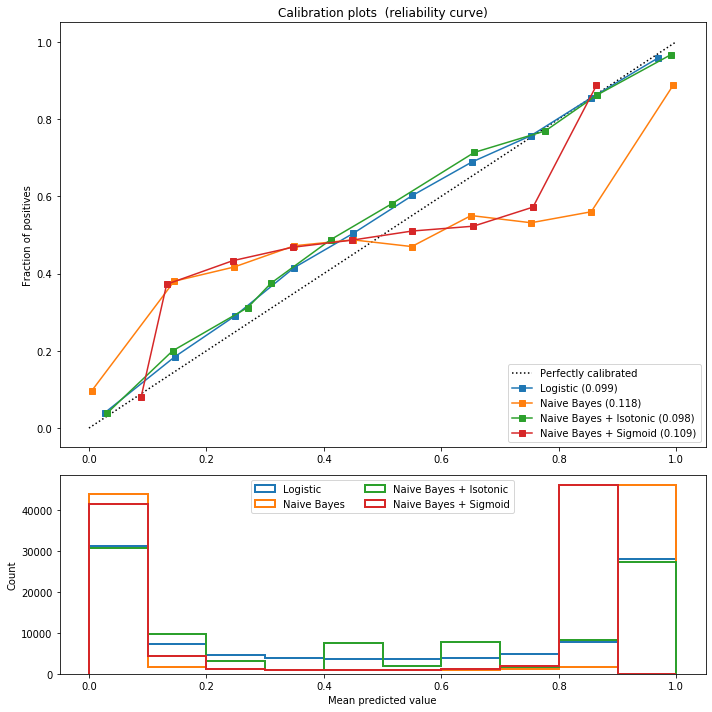

In [45]:
# Logistic regression with no calibration as baseline
lr = LogisticRegression(C=1.)

fig = plt.figure(fig_index, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (est, name),
                  (isotonic, name + ' + Isotonic'),
                  (sigmoid, name + ' + Sigmoid')]:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

    clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
    print("%s:" % name)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
    print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%1.3f)" % (name, clf_score))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name, histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

In [ ]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

In [ ]:
# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(est=GaussianNB(), name="Naive Bayes", fig_index=1)

# Plot calibration curve for Linear SVC
plot_calibration_curve(est=LinearSVC(max_iter=10000), name="SVC", fig_index=2)

plt.show()